In [ ]:
1200 + 

In [20]:
import math
import numpy as np
import scipy as sp
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import os
from scipy.interpolate import InterpolatedUnivariateSpline

from qfin.utils import bs_explicit_call, bs_call_delta, bs_gamma, bs_vega, interpolate

In [21]:
def integrate(strategy, paths, initial_price, rate, dt=1/365):

    k, n, m = paths.shape
    pnl = initial_price - np.sum(strategy[:, :, 0] * paths[:, :, 0], axis=0)

    for i in range(1, m - 1):
        pnl = np.exp(rate * dt) * pnl - np.sum((strategy[:, :, i] - strategy[:, :, i - 1]) * paths[:, :, i], axis=0)

    pnl *= np.exp(rate * dt)
    pnl += np.sum((strategy[:, :, m - 2]) * paths[:, :, m - 1], axis=0)

    return pnl

In [22]:
T = 3/12
dt = 1/365

K1 = 100
K2 = 105
s0 = 100

n = 20000
m = int(T / dt + 1)

rate = 0.05
sigma = 0.2

In [23]:
# generate paths

z = np.random.standard_normal((n, m-1))
s = s0 * np.exp(np.cumsum(np.pad((rate - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * z, ((0, 0), (1, 0))), axis=1))

ttm = np.linspace(T, 0, s.shape[1])
c = bs_explicit_call(ttm, K2, s, rate, sigma)
c[:, -1] = np.maximum(s[:, -1] - K2, 0)

paths = np.array([s, c])

# Delta hedging

(array([1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        5.000e+00, 1.100e+01, 2.100e+01, 3.000e+01, 4.000e+01, 9.600e+01,
        1.550e+02, 3.210e+02, 5.970e+02, 1.124e+03, 1.903e+03, 3.006e+03,
        3.912e+03, 3.442e+03, 2.312e+03, 1.439e+03, 7.580e+02, 4.150e+02,
        2.270e+02, 8.400e+01, 6.200e+01, 1.700e+01, 1.000e+01, 4.000e+00]),
 array([-0.59053616, -0.55884271, -0.52714927, -0.49545582, -0.46376238,
        -0.43206893, -0.40037549, -0.36868204, -0.33698859, -0.30529515,
        -0.2736017 , -0.24190826, -0.21021481, -0.17852137, -0.14682792,
        -0.11513448, -0.08344103, -0.05174759, -0.02005414,  0.0116393 ,
         0.04333275,  0.0750262 ,  0.10671964,  0.13841309,  0.17010653,
         0.20179998,  0.23349342,  0.26518687,  0.29688031,  0.32857376,
         0.3602672 ]),
 <BarContainer object of 30 artists>)

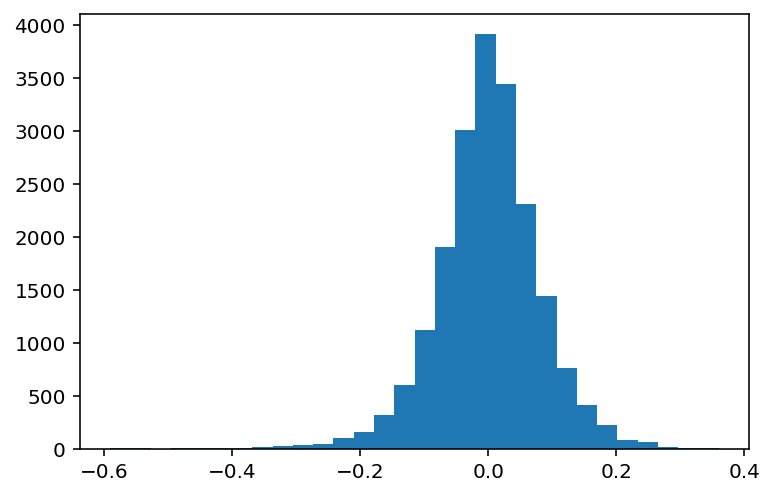

In [27]:
strategy = np.zeros(paths.shape)
strategy[0] = bs_call_delta(ttm, K1, s, rate, sigma)

# setup initial price
initial_price = bs_explicit_call(T, K1, s0, rate, sigma)

# integrate
pnl = integrate(strategy, paths, initial_price, rate)

# liabilities
pnl -= np.maximum(s[:, -1] - K1, 0)

# relative hedge
pnl = pnl / initial_price

# plot pnl
plt.hist(pnl, bins=30)

# Delta and gamma hedging

/Users/konstantinisstarovoitovs/projects/chris/qfin/utils.py:37: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(spot / strike) + (rate + 0.5 * SIGMA ** 2) * ttm) / (SIGMA * np.sqrt(ttm))
/Users/konstantinisstarovoitovs/projects/chris/qfin/utils.py:38: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1) / (spot * SIGMA * np.sqrt(ttm))
<ipython-input-11-1a591efeeee7>:3: RuntimeWarning: divide by zero encountered in true_divide
  g = bs_gamma(ttm, K1, s, rate, sigma) / bs_gamma(ttm, K2, s, rate, sigma)
<ipython-input-11-1a591efeeee7>:4: RuntimeWarning: invalid value encountered in multiply
  g *= bs_gamma(ttm, K1, s, rate, sigma) > 1e-2


(array([1.0000e+00, 0.0000e+00, 5.0000e+00, 3.0000e+00, 1.5000e+01,
        1.8000e+01, 3.7000e+01, 9.5000e+01, 2.7200e+02, 8.9700e+02,
        1.1263e+04, 6.1670e+03, 8.0900e+02, 3.1600e+02, 7.2000e+01,
        1.5000e+01, 3.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.46638455, -0.42362933, -0.38087412, -0.33811891, -0.29536369,
        -0.25260848, -0.20985327, -0.16709806, -0.12434284, -0.08158763,
        -0.03883242,  0.0039228 ,  0.04667801,  0.08943322,  0.13218844,
         0.17494365,  0.21769886,  0.26045408,  0.30320929,  0.3459645 ,
         0.38871971,  0.43147493,  0.47423014,  0.51698535,  0.55974057,
         0.60249578,  0.64525099,  0.68800621,  0.73076142,  0.77351663,
         0.81627184]),
 <BarContainer object of 30 artists>)

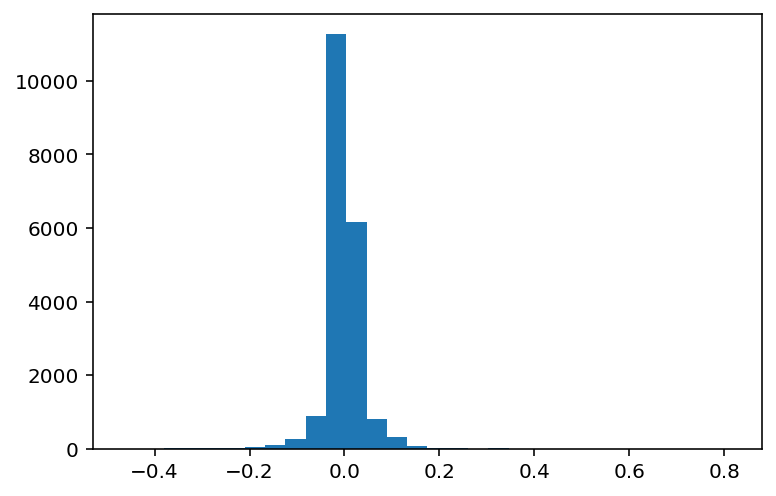

In [11]:
strategy = np.zeros(paths.shape)

g = bs_gamma(ttm, K1, s, rate, sigma) / bs_gamma(ttm, K2, s, rate, sigma)
g *= bs_gamma(ttm, K1, s, rate, sigma) > 1e-2
g *= bs_gamma(ttm, K2, s, rate, sigma) > 1e-2

d = bs_call_delta(ttm, K1, s, rate, sigma) - g * bs_call_delta(ttm, K2, s, rate, sigma)

strategy[0] = d
strategy[1] = g

# setup initial price
initial_price = bs_explicit_call(T, K1, s0, rate, sigma)

# integrate
pnl = integrate(strategy, paths, initial_price, rate)

# liabilities
pnl -= np.maximum(s[:, -1] - K1, 0)

# relative hedge
pnl = pnl / initial_price

# plot pnl
plt.hist(pnl, bins=30)